In [34]:
library(tidyverse)
library(data.table)
library(plotly) # for interactive ploting
library(DT) # for interactive tabulation
library(broom) # for tidy statistical summaries
library(caret) # for regression performance measures

In [35]:
options(repr.matrix.max.rows=20, repr.matrix.max.cols=15) # for limiting the number of top and bottom rows of tables printed 

In [36]:
datapath <- "~/data_ad454"

# Simple Linear Regression

In this session we will conduct a simple linear regression using one dependent variable and one independent variable.

We will split the dataset into train and test partitions

Let's first import the realty dataset:

In [37]:
realty_data <- readRDS(sprintf("%s/rds/02_01_realty_data.rds", datapath))

In [38]:
realty_data

price,province,district,neighborhood,oda,salon,brut_metrekare,net_metrekare,⋯,teras,toplu_ulasima_yakin,tramvaya_yakin,vestiyer,yangin_merdiveni,yerden_isitma,yuzme_havuzu
<int>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
690000,istanbul,sisli,fulya,4,2,180,NA,⋯,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE
440000,istanbul,sisli,fulya,3,1,120,NA,⋯,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE
490000,istanbul,sisli,mecidiyekoy,4,1,160,NA,⋯,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE
580000,istanbul,sisli,mecidiyekoy,2,1,100,NA,⋯,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE
645000,istanbul,sisli,gulbahar,2,1,70,65,⋯,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE
420000,istanbul,sisli,fulya,2,1,75,NA,⋯,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE
160000,istanbul,sisli,mecidiyekoy,2,1,80,70,⋯,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE
382000,istanbul,sisli,gulbahar,3,2,140,NA,⋯,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE
360000,istanbul,sisli,gulbahar,2,1,110,NA,⋯,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE


Let's see the structure:

In [39]:
realty_data %>% str

Classes ‘data.table’ and 'data.frame':	994 obs. of  121 variables:
 $ price                  : int  690000 440000 490000 580000 645000 420000 160000 382000 360000 450000 ...
 $ province               : Factor w/ 1 level "istanbul": 1 1 1 1 1 1 1 1 1 1 ...
 $ district               : Factor w/ 1 level "sisli": 1 1 1 1 1 1 1 1 1 1 ...
 $ neighborhood           : Factor w/ 6 levels "fulya","gulbahar",..: 1 1 5 5 2 1 5 2 2 5 ...
 $ oda                    : int  4 3 4 2 2 2 2 3 2 3 ...
 $ salon                  : int  2 1 1 1 1 1 1 2 1 1 ...
 $ brut_metrekare         : int  180 120 160 100 70 75 80 140 110 125 ...
 $ net_metrekare          : int  NA NA NA NA 65 NA 70 NA NA NA ...
 $ bina_yasi              : int  20 24 3 38 20 25 20 10 0 15 ...
 $ isinma_tipi            : Factor w/ 8 levels "jeotermal isitma",..: 4 4 4 4 4 5 4 4 4 4 ...
 $ ilan_tarihi            : Date, format: "2018-11-28" "2018-12-02" ...
 $ konut_tipi             : Factor w/ 1 level "satilik daire": 1 1 1 1 1 1 1 1 1 1 ..

You can navigate through and filter the data:

In [40]:
realty_data %>% datatable(
  filter = "top",
  options = list(pageLength = 20)
)

HTML widgets cannot be represented in plain text (need html)

See which variables are of factor type and what the levels of each are:

In [41]:
realty_data %>% keep(is.factor) %>% lapply(levels)

$province
[1] "istanbul"

$district
[1] "sisli"

$neighborhood
[1] "fulya"       "gulbahar"    "izzetpasa"   "kustepe"     "mecidiyekoy"
[6] "merkez"     

$isinma_tipi
[1] "jeotermal isitma"    "kat kaloriferi"      "klima"              
[4] "kombi"               "merkezi"             "merkezi (pay olcer)"
[7] "soba"                "yok"                

$konut_tipi
[1] "satilik daire"

$konut_sekli
[1] "bahce dubleksi" "bahce kati"     "cati dubleksi"  "daire"         
[5] "dubleks"        "mustakil ev"   

$esyali
[1] "evet"  "hayir"

$kat2
 [1] "21 ve uzeri"     "ara kat"         "bahce kati"      "bodrum ve zemin"
 [5] "cati kati"       "en ust kat"      "giris kati"      "kot 1"          
 [9] "kot 2"           "kot 3"           "teras kati"      "yari bodrum"    
[13] "yuksek giris"    "zemin"          

$yakit_tipi
[1] "dogalgaz"   "elektrik"   "komur-odun"

$yapi_tipi
[1] "ahsap"     "betonarme" "kagir"    

$yapinin_durumu
[1] "ikinci el"        "sifir"            "yapim asamasinda"

$kullanim_durumu
[1] "bos"                "ev sahibi oturuyor" "kiraci oturuyor"   

$tapu_durumu
[1] "arsa"          "kat irtifaki"  "kat mulkiyeti"

$krediye_uygunluk
[1] "uygun"       "uygun degil"

$ogrenciye_bekara
[1] "evet"  "hayir"

$yetkili_ofis
[1] "var" "yok"

$takas
[1] "evet"  "hayir"

$site
[1] " selenium residence"           "evet (site adi belirtilmemis)"
[3] "guaj mecidiyekoy"              "guaj yapi"                    
[5] "hilton sitesi"                 "konsep"                       
[7] "polat ciftciler residence"     "terrace fulya"

And the frequencies of those levels:

In [42]:
realty_data %>% keep(is.factor) %>% summary

     province    district        neighborhood              isinma_tipi 
 istanbul:994   sisli:994   fulya      :301   kombi              :861  
                            gulbahar   :220   merkezi            : 86  
                            izzetpasa  : 27   merkezi (pay olcer): 23  
                            kustepe    : 60   kat kaloriferi     : 11  
                            mecidiyekoy:385   jeotermal isitma   :  3  
                            merkez     :  1   (Other)            :  7  
                                              NA's               :  3  
         konut_tipi          konut_sekli    esyali              kat2    
 satilik daire:994   bahce dubleksi:  1   evet : 60   yuksek giris: 61  
                     bahce kati    : 32   hayir:925   bahce kati  : 52  
                     cati dubleksi : 68   NA's :  9   giris kati  : 50  
                     daire         :772               kot 1       : 41  
                     dubleks       : 67               kot 2

Let's see the numeric variables:

In [43]:
realty_data %>% keep(is.numeric) %>% names

[1] "price"          "oda"            "salon"          "brut_metrekare"
 [5] "net_metrekare"  "bina_yasi"      "banyo_sayisi"   "kat_sayisi"    
 [9] "kat"            "kira_getirisi"  "aidat"          "depozito"

And statistical summaries of numeric columns:

In [44]:
realty_data %>% keep(is.numeric) %>% summary()

     price               oda            salon       brut_metrekare 
 Min.   :  135000   Min.   :1.000   Min.   :1.000   Min.   : 45.0  
 1st Qu.:  295000   1st Qu.:2.000   1st Qu.:1.000   1st Qu.: 75.0  
 Median :  450000   Median :2.000   Median :1.000   Median : 90.0  
 Mean   :  590459   Mean   :2.302   Mean   :1.044   Mean   :102.8  
 3rd Qu.:  680000   3rd Qu.:3.000   3rd Qu.:1.000   3rd Qu.:125.0  
 Max.   :22220000   Max.   :7.000   Max.   :2.000   Max.   :500.0  
                                                                   
 net_metrekare      bina_yasi      banyo_sayisi     kat_sayisi    
 Min.   : 50.00   Min.   : 0.00   Min.   :1.000   Min.   : 1.000  
 1st Qu.: 70.00   1st Qu.: 0.00   1st Qu.:1.000   1st Qu.: 4.000  
 Median : 85.00   Median :10.00   Median :1.000   Median : 5.000  
 Mean   : 94.13   Mean   :12.86   Mean   :1.245   Mean   : 5.425  
 3rd Qu.:110.00   3rd Qu.:25.00   3rd Qu.:1.000   3rd Qu.: 6.000  
 Max.   :250.00   Max.   :58.00   Max.   :5.000   Max.

And statistical summaries of numeric columns in a better format:

In [45]:
realty_data %>% keep(is.numeric) %>% broom::tidy() %>% mutate_if(is.numeric, round, 2) %>%
select(column, n, mean, sd, median, min, max)

Warning message:
“Data frame tidiers are deprecated and will be removed in an upcoming release of broom.”


column,n,mean,sd,median,min,max
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
price,994,590459.26,842033.62,450000,135000,22220000
oda,994,2.30,0.85,2,1,7
salon,994,1.04,0.21,1,1,2
brut_metrekare,994,102.82,38.97,90,45,500
net_metrekare,208,94.13,33.62,85,50,250
bina_yasi,994,12.86,12.88,10,0,58
banyo_sayisi,994,1.25,0.46,1,1,5
kat_sayisi,932,5.42,2.68,5,1,42
kat,668,3.31,1.98,3,1,15


Now let's select some of the features

In [46]:
features <- c("price", "brut_metrekare",
             "krediye_uygunluk",
             "kira_getirisi")

Let's create the unit price column and unit rent column, filter for "eligible for loan" (krediye uygun) rows and trim 5% top and bottom unit price and unit_rent values:

In [47]:
realty_data2 <- realty_data %>%
select(all_of(features)) %>%
mutate(unit_price = price / brut_metrekare) %>%
mutate(unit_rent = kira_getirisi / brut_metrekare) %>%
filter(krediye_uygunluk == "uygun") %>%
na.omit %>%
filter(between(unit_price, quantile(unit_price, 0.05), quantile(unit_price, 0.95))) %>%
filter(between(unit_rent, quantile(unit_rent, 0.05), quantile(unit_rent, 0.95)))

In [48]:
realty_data2 %>% str

Classes ‘data.table’ and 'data.frame':	431 obs. of  6 variables:
 $ price           : int  440000 490000 580000 420000 900000 425000 410000 580000 235000 500000 ...
 $ brut_metrekare  : int  120 160 100 75 125 80 75 80 75 150 ...
 $ krediye_uygunluk: Factor w/ 2 levels "uygun","uygun degil": 1 1 1 1 1 1 1 1 1 1 ...
 $ kira_getirisi   : int  2200 2500 2200 1750 2800 1500 1700 2500 1450 2250 ...
 $ unit_price      : num  3667 3062 5800 5600 7200 ...
 $ unit_rent       : num  18.3 15.6 22 23.3 22.4 ...
 - attr(*, ".internal.selfref")=<externalptr> 


Now we will try to understand whether unit_price is related to unit_rent.

## Visual examination:

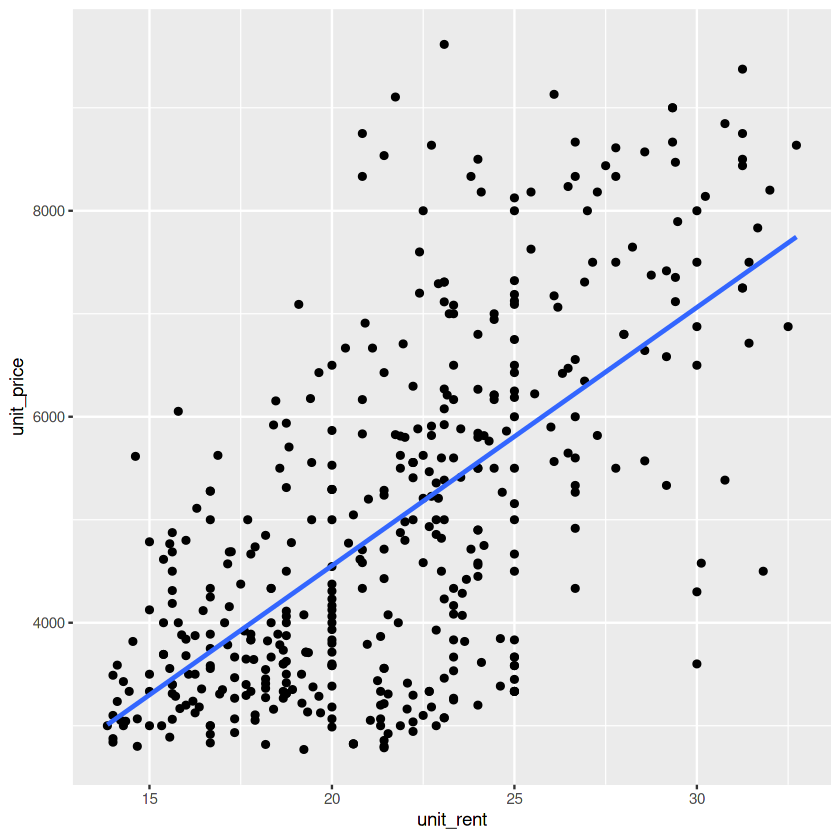

In [49]:
realty_data2 %>% ggplot(aes(x = unit_rent,
                           y = unit_price)) +
                        geom_point() +
geom_smooth(method = "lm", formula = y ~ x, se = F)

We see a positive and slightly strong relationship

## Partition

Let's determine a ratio for train partition:

In [50]:
train_ratio <- 0.7

Randomly create row indices for train partition

In [51]:
train_indices <- realty_data2[,sample(.N * train_ratio)]

Split the data into two partitions

In [52]:
train_data <- realty_data2[train_indices]
test_data <- realty_data2[-train_indices]

Check whether partitions are mutually exclusive:

In [53]:
realty_data2[,.N]
train_data[,.N]
test_data[,.N]

[1] 431

[1] 301

[1] 130

## Train the model

Let's create the model:

In [54]:
model1 <- lm(unit_price ~ unit_rent, data = train_data)

See the summary:

In [55]:
summary(model1)


Call:
lm(formula = unit_price ~ unit_rent, data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3570.4  -761.8  -104.5   829.6  4045.8 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -498.93     369.07  -1.352    0.177    
unit_rent     255.65      16.73  15.281   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1278 on 299 degrees of freedom
Multiple R-squared:  0.4385,	Adjusted R-squared:  0.4366 
F-statistic: 233.5 on 1 and 299 DF,  p-value: < 2.2e-16


tidy() from broom package extract and present useful information from the model in a tabulated manner:

In [56]:
tidy(model1)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-498.9312,369.06791,-1.351868,1.774392e-01
unit_rent,255.6456,16.72984,15.280820,2.336509e-39


What we see is:

- The coefficient on unit_rent is significantly differant than 0, (statistically significant)
- 44% of the overall variance in unit_price is explained by the model
- When unit_rent is zero, unit_price is estimated to be negative. Maintenance costs and due fees (aidat) may be reason for that

How can you interpret the coefficient of unit_rent?

## Predict the model

We have actual and predicted unit_price values for the train and test sets:

In [57]:
actual_train <- train_data$unit_price
predicted_train <- predict(model1, train_data)

In [58]:
actual_test <- test_data$unit_price
predicted_test <- predict(model1, test_data)

The test data was not utilized when we created the model, so it is unseen data. If the model performs well on train but not on test data, we may conclude that the model "memorized" and not learned the data

Some information on regression performance metrics can be found following the links:

[Regression Model Accuracy (MAE, MSE, RMSE, R-squared) Check in R](https://www.datatechnotes.com/2019/02/regression-model-accuracy-mae-mse-rmse.html)

[Measuring Performance](https://topepo.github.io/caret/measuring-performance.html)

We calculate the R2, RMSE and MAE values using caret package for train and test predictions vs actual values:

In [59]:
model_dt <- data.table(partition = c("train", "test"),
                       R2 = c(R2(predicted_train, actual_train),
                                R2(predicted_test, actual_test)),
                        RMSE = c(RMSE(predicted_train, actual_train),
                                 RMSE(predicted_test, actual_test)),
                        MAE = c(MAE(predicted_train, actual_train),
                                MAE(predicted_test, actual_test))
                        )

In [60]:
model_dt

partition,R2,RMSE,MAE
<chr>,<dbl>,<dbl>,<dbl>
train,0.4385013,1273.443,999.2987
test,0.3560815,1345.589,1053.9987


We see that R2 is lower (but not too much) for the test set as compared to its level for the train set. The higher R2 the better the fit is

RMSE and MAE measures are higher for the test set as compared to their levels for the train set. The lower the RMSE and MAE measures the better the fit is.

So test performance of the model is slightly lower than its performance on the train set but the difference is not very high.

Note that, the scales of RMSE and MAE measures are not standardized, they are dependent on the scale of the target feature. However R2 is a standardized measure: It is always between 0 and 1

We can also plot the actual vs. predicted values to see how well the model performs.

Note that we add a diagonal line to better see the fit. For more information on such lines please follow:

[Reference lines: horizontal, vertical, and diagonal](https://ggplot2.tidyverse.org/reference/geom_abline.html)

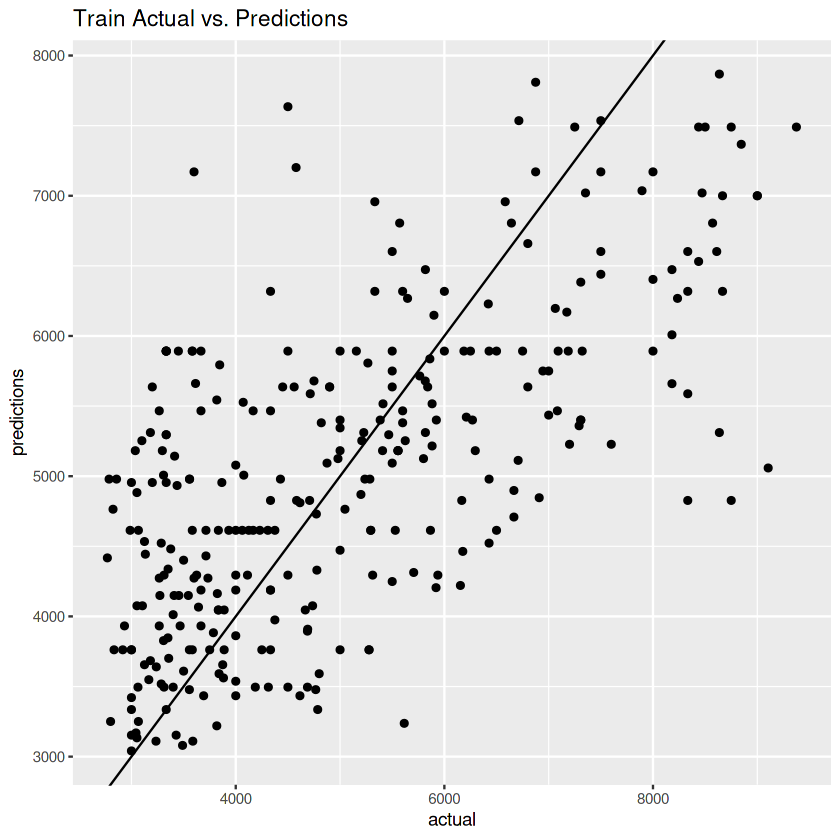

In [61]:
data.table(actual = actual_train, predictions = predicted_train) %>%
ggplot(aes(x = actual, y = predictions)) +
geom_point() +
geom_abline(slope = 1, intercept = 0) +
ggtitle("Train Actual vs. Predictions")

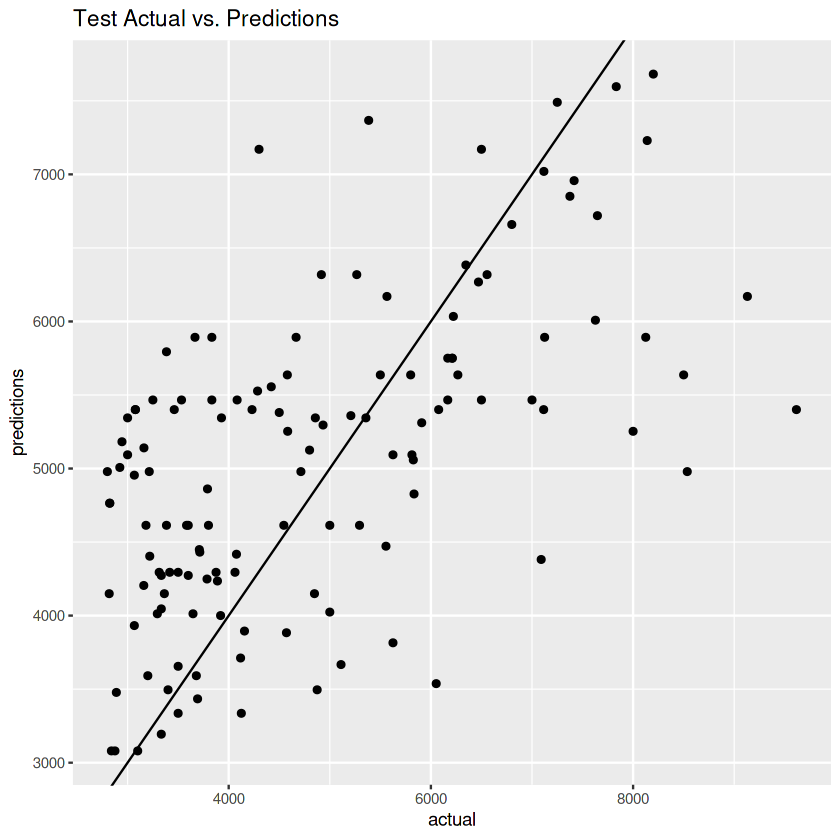

In [62]:
data.table(actual = actual_test, predictions = predicted_test) %>%
ggplot(aes(x = actual, y = predictions)) +
geom_point() +
geom_abline(slope = 1, intercept = 0) +
ggtitle("Test Actual vs. Predictions")